# 95891 Introduction to Artificial Intelligence - Group Project
### What To Buy: A Recommendation System for Amazon Based on Co-Purchasing Behavior

**I. Team Members**

David Tsai (chishiut), Judy Tsai (weiyit), Lili Chen (lilichen), Yilin Lyu (yilinlyu), Abigail Zhang (tianaiz)

**II. Project Description**

Our goal is to analyze and leverage the co-purchasing behavior of Amazon customers to make product recommendations and uncover patterns and insights related to product associations. This can help find potential sales boost opportunities and improve customer’s shopping experience.

**III. Our Approach**

We divide our groups into two subteams based on the models we use. The GNN team (David, Judy, and Lili) uses the graph neural network (GNN) model and the ML team (Yilin and Abigail) focuses on machine learning models. The two teams will then work together to analyze the results and decide on the best model to use.

This jupyter notebook contains the code for ML model training and evaluation.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score

## Purchasing data processing

In [ ]:
metadata = pd.read_csv('metadata_cleaned_lili_111723.csv')

In [ ]:

train1 = pd.read_csv('train1.csv')
train2 = pd.read_csv('train2.csv')
train3 = pd.read_csv('train3.csv')

In [ ]:
test=pd.read_csv('test.csv')

In [ ]:
test

,Unnamed: 0,PurchaseFirst,PurchaseSecond
0,0,0,1
1,1,0,2
2,2,0,3
3,3,0,4
4,4,0,5
...,...,...,...
3387383,3387383,403392,121379
3387384,3387384,403392,190663
3387385,3387385,403393,318438
3387386,3387386,403393,326962


In [ ]:
train=pd.concat([train1,train2,train3],axis=0)
train=train.drop(columns=['Unnamed: 0'],axis=1)


In [ ]:
train

,PurchaseFirst,PurchaseSecond
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
3356819,410235,410230
3356820,410235,410231
3356821,410235,410232
3356822,410235,410233


In [ ]:
# ensure all the item in testing data were in training data. data filtering
test= test[test['PurchaseFirst'].isin(train['PurchaseFirst'])]
test=test.drop(columns='Unnamed: 0')
test

,PurchaseFirst,PurchaseSecond
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
3387383,403392,121379
3387384,403392,190663
3387385,403393,318438
3387386,403393,326962


## Metadata Processing

In [ ]:
metadata=metadata[['Id','Salesrank', 'Group', 'Average_Rating', 'Main_Category']]


In [ ]:
le=LabelEncoder()

metadata['Main_Category'] = le.fit_transform(metadata['Main_Category'])
metadata['Group'] = le.fit_transform(metadata['Group'])
metadata.head()

,Id,Salesrank,Group,Average_Rating,Main_Category
0,0,NaN,10,NaN,761
1,1,396585.0,1,5.0,221
2,2,168596.0,1,4.5,284
3,3,1270652.0,1,5.0,253
4,4,631289.0,1,4.0,221


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
Metadata_subset=metadata[['Salesrank','Average_Rating']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Metadata_subset)
X_scaled=pd.DataFrame(X_scaled)
metadata[['Salesrank','Average_Rating']] = X_scaled
metadata

,Id,Salesrank,Group,Average_Rating,Main_Category
0,0,NaN,10,NaN,761
1,1,-0.163353,1,0.896895,221
2,2,-0.564939,1,0.646431,284
3,3,1.376249,1,0.896895,253
4,4,0.250060,1,0.395966,221
...,...,...,...,...,...
548547,548547,-0.861908,3,0.896895,721
548548,548548,-0.861908,3,-0.104962,436
548549,548549,-0.861908,1,0.395966,680
548550,548550,-0.861908,3,0.896895,517


## Approach 1
- 1.1 prepare training and testing data to be the same with approach 1
- 1.2 merge purchase data with metadata to provide features about the first purchsed item
- 1.3 fit model to predict which item will be purchase second


### 1.1 Prepare Train and Test

In [ ]:
random_seed = 42
train = train.sample(frac=1,random_state=random_seed).reset_index(drop=True)
train=train[:10000]
train=train.rename(columns={'PurchaseFirst':'Id'})
train

,Id,PurchaseSecond
0,247505,99545
1,344432,344431
2,136967,51463
3,193288,133793
4,214185,175809
...,...,...
9995,50451,65655
9996,370663,289960
9997,408490,408491
9998,79049,79046


In [ ]:
random_seed = 42
test = test.sample(frac=1,random_state=random_seed).reset_index(drop=True)
test=test[:10000]
test=test.rename(columns={'PurchaseFirst':'Id'})
test

,Id,PurchaseSecond
0,133358,155189
1,311572,259244
2,131607,138974
3,286820,48514
4,40865,37625
...,...,...
9995,165034,165027
9996,362379,39224
9997,347034,381043
9998,255615,255613


### 1.2 Merge purchase data

In [ ]:
train_merged=pd.merge(metadata, train,on='Id', how='left')
train_merged=train_merged.dropna()
train_merged

,Id,Salesrank,Group,Average_Rating,Main_Category,PurchaseSecond
148,148,-0.726264,1,0.395966,135,147.0
210,210,3.704179,1,-1.607746,323,2311.0
214,214,0.406943,1,0.395966,578,106.0
276,276,0.210717,1,0.646431,383,528.0
286,286,-0.621288,4,-1.607746,722,355.0
...,...,...,...,...,...,...
409591,409457,-0.454520,1,0.646431,537,409021.0
409642,409508,0.021945,1,0.646431,662,409537.0
409953,409819,1.958504,1,-1.607746,105,267459.0
410063,409929,-0.205057,1,0.395966,311,409934.0


In [ ]:
test_merged=pd.merge(metadata,test, on='Id', how='left')
test_merged=test_merged.dropna()
test_merged

,Id,Salesrank,Group,Average_Rating,Main_Category,PurchaseSecond
2,2,-0.564939,1,0.646431,284,355.0
8,8,-0.373273,1,0.646431,586,44.0
17,17,0.142426,1,0.145502,488,2483.0
37,37,-0.780850,3,0.145502,705,32.0
79,79,-0.848808,1,0.646431,751,34.0
...,...,...,...,...,...,...
403317,403218,0.139539,1,0.896895,145,403118.0
403323,403224,0.596796,1,0.145502,586,2300.0
403325,403226,-0.306908,1,0.896895,203,323720.0
403445,403346,0.602142,1,0.395966,531,403351.0


### 1.3 Fit model

In [ ]:
X_train=train_merged.drop('PurchaseSecond',axis=1)
y_train=train_merged['PurchaseSecond']

In [ ]:
X_test=test_merged.drop('PurchaseSecond',axis=1)
y_test=test_merged['PurchaseSecond']

### 1.3.1 KNN

In [ ]:
knn_model = KNeighborsClassifier()

# Train the model
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred = knn_model.predict(X_train)

# Calculate F1 score
f1 = f1_score(y_train, y_pred, average='macro')

# Calculate precision
precision = precision_score(y_train, y_pred, average='macro')

# Print the scores
print(f"Train F1 Score: {f1}")
print(f"Train Precision: {precision}")

Train F1 Score: 0.08683214947509997
Train Precision: 0.06067156217628492


C:\Users\luyil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Make predictions on the test set
y_pred = knn_model.predict(X_test)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='macro')

# Calculate precision
precision = precision_score(y_test, y_pred, average='macro')

# Print the scores
print(f"Test F1 Score: {f1}")
print(f"Test Precision: {precision}")

Test F1 Score: 1.813022943805354e-05
Test Precision: 1.0198254058905115e-05


C:\Users\luyil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
1.813022943805354e-05/0.08683214947509997

0.00020879627589148386

### 1.3.2 Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier()

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions on the training set
y_pred_train = dt_model.predict(X_train)

# Calculate F1 score and precision for the training set
f1_train = f1_score(y_train, y_pred_train, average='macro')
precision_train = precision_score(y_train, y_pred_train, average='macro')

# Print the scores for the training set
print(f"Train F1 Score: {f1_train}")
print(f"Train Precision: {precision_train}")

# Make predictions on the test set
y_pred_test = dt_model.predict(X_test)

# Calculate F1 score and precision for the test set
f1_test = f1_score(y_test, y_pred_test, average='macro')
precision_test = precision_score(y_test, y_pred_test, average='macro')

# Print the scores for the test set
print(f"Test F1 Score: {f1_test}")
print(f"Test Precision: {precision_test}")

C:\Users\luyil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train F1 Score: 0.9821184167938225
Train Precision: 0.9800215009016507
Test F1 Score: 0.0
Test Precision: 0.0


C:\Users\luyil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Initialize the Decision Tree Regressor model
dt_regressor = DecisionTreeRegressor()

# Train the model
dt_regressor.fit(X_train, y_train)

# Make predictions on the training set
y_pred_train = dt_regressor.predict(X_train)

# Calculate MSE and R-squared for the training set
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = sqrt(mse_train)
r2_train = r2_score(y_train, y_pred_train)

# Print the scores for the training set
print(f"Train MSE: {mse_train}")
print(f"Train RMSE: {rmse_train}")
print(f"Train R-squared: {r2_train}")

# Make predictions on the test set
y_pred_test = dt_regressor.predict(X_test)

# Calculate MSE and R-squared for the test set
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

# Print the scores for the test set
print(f"Test MSE: {mse_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test R-squared: {r2_test}")

Train MSE: 50889743.65564097
Train RMSE: 7133.704763700343
Train R-squared: 0.9956200322456121
Test MSE: 14930800234.269302
Test RMSE: 122191.65370134452
Test R-squared: -0.14160135904172755


In [ ]:
# Get probabilities for each class for each instance
probabilities = knn_model.predict_proba(X_train)

# Counter for how many times the actual label is in the top 10 predictions
top_10_hit_count = 0

# Iterate over each instance and its corresponding actual label
for i in range(len(probabilities)):
    # Get the indices of the top 10 probabilities
    # np.argsort returns indices that would sort the array, and we take the last 10 indices for the highest probabilities
    top_10_indices = np.argsort(probabilities[i])[-1000:]

    # Check if the actual label is in the top 10 predictions
    if y_train.iloc[i] in top_10_indices:
        top_10_hit_count += 1

# Calculate the percentage
percentage_top_10 = (top_10_hit_count / len(probabilities)) * 100

# Print the percentage
print(f"Percentage of instances where actual 'PurchaseSecond' is in the top 10 predictions: {percentage_top_10:.2f}%")

Percentage of instances where actual 'PurchaseSecond' is in the top 10 predictions: 0.74%


In [ ]:

# Get probabilities for each class for each instance
probabilities = knn_model.predict_proba(X_test)

# Counter for how many times the actual label is in the top 10 predictions
top_10_hit_count = 0

# Iterate over each instance and its corresponding actual label
for i in range(len(probabilities)):
    # Get the indices of the top 10 probabilities
    # np.argsort returns indices that would sort the array, and we take the last 10 indices for the highest probabilities
    top_10_indices = np.argsort(probabilities[i])[-1000:]

    # Check if the actual label is in the top 10 predictions
    if y_test.iloc[i] in top_10_indices:
        top_10_hit_count += 1

# Calculate the percentage
percentage_top_10 = (top_10_hit_count / len(probabilities)) * 100

# Print the percentage
print(f"Percentage of instances where actual 'PurchaseSecond' is in the top 10 predictions: {percentage_top_10:.2f}%")

Percentage of instances where actual 'PurchaseSecond' is in the top 10 predictions: 0.82%


## Add more features back !

In [ ]:
metadata = pd.read_csv('metadata_cleaned_lili_111723.csv')
metadata=metadata.drop(columns=['Unnamed: 0','Title','ASIN','Similar_Count','Similar_Products','Categories','All_Reviews','Is_Discontinued_Product'],axis=1)
metadata=metadata.drop(columns=['Categories_Hierarchy'])
metadata=metadata.dropna(subset=['Salesrank','Total_Reviews'])

In [ ]:
metadata['category_1'] = le.fit_transform(metadata['category_1'])
metadata['category_2'] = le.fit_transform(metadata['category_2'])
metadata['category_3'] = le.fit_transform(metadata['category_3'])
metadata['category_4'] = le.fit_transform(metadata['category_4'])
metadata['category_5'] = le.fit_transform(metadata['category_5'])
metadata['category_6'] = le.fit_transform(metadata['category_6'])
metadata['Main_Category'] = le.fit_transform(metadata['Main_Category'])
metadata['Group'] = le.fit_transform(metadata['Group'])

In [ ]:
metadata_subset=metadata[['Salesrank','Total_Reviews','Downloaded_Reviews','Average_Rating']]
scaler = StandardScaler()
metadata_scaled = scaler.fit_transform(metadata_subset)
metadata[['Salesrank', 'Total_Reviews', 'Downloaded_Reviews', 'Average_Rating']] = metadata_scaled

In [ ]:
train2_merged=pd.merge(metadata, train,on='Id', how='left')
train2_merged=train2_merged.dropna()
test2_merged=pd.merge(metadata,test, on='Id', how='left')
test2_merged=test2_merged.dropna()
test2_merged

,Id,Group,Salesrank,Total_Reviews,Downloaded_Reviews,Average_Rating,category_1,category_2,category_3,category_4,category_5,category_6,Main_Category,PurchaseSecond
1,2,1,-0.564939,-0.031294,-0.027702,0.646431,0,20,84,352,7088,8973,284,355.0
7,8,1,-0.373273,0.008830,0.014018,0.646431,0,20,74,739,3627,8973,586,44.0
16,17,1,0.142426,-0.151666,-0.152861,0.145502,0,20,38,620,5127,3100,488,2483.0
36,37,3,-0.780850,-0.098168,-0.097235,0.145502,2,8,46,893,3774,8973,705,32.0
78,79,1,-0.848808,-0.031294,-0.027702,0.646431,0,20,74,967,3643,8973,751,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398739,403218,1,0.139539,-0.178415,-0.180675,0.896895,0,20,25,159,5498,2996,145,403118.0
398744,403224,1,0.596796,-0.138291,-0.138955,0.145502,0,20,74,739,4347,8973,586,2300.0
398746,403226,1,-0.306908,-0.178415,-0.180675,0.896895,0,20,101,228,6865,2944,203,323720.0
398865,403346,1,0.602142,1.961529,2.030473,0.395966,0,20,71,672,3623,1450,531,403351.0


In [ ]:
X2_train=train2_merged.drop('PurchaseSecond',axis=1)
y2_train=train2_merged['PurchaseSecond']

In [ ]:
X2_test=test2_merged.drop('PurchaseSecond',axis=1)
y2_test=test2_merged['PurchaseSecond']

In [ ]:
X2_train

,Id,Group,Salesrank,Total_Reviews,Downloaded_Reviews,Average_Rating,category_1,category_2,category_3,category_4,category_5,category_6,Main_Category
147,148,1,-0.726264,0.369945,0.389496,0.395966,0,20,87,148,129,4451,135
209,210,1,3.704179,-0.191790,-0.194581,-1.607746,0,20,87,402,3697,8973,323
213,214,1,0.406943,-0.178415,-0.180675,0.395966,0,20,8,730,5726,5008,578
275,276,1,0.210717,-0.071418,-0.069422,0.646431,0,20,74,487,2789,8973,383
285,286,4,-0.621288,-0.191790,-0.194581,-1.607746,7,1,100,228,1055,6297,722
...,...,...,...,...,...,...,...,...,...,...,...,...,...
404948,409457,1,-0.454520,-0.151666,-0.152861,0.646431,0,20,31,679,4610,1283,537
404998,409508,1,0.021945,0.142576,0.153084,0.646431,0,20,99,837,6272,7621,662
405306,409819,1,1.958504,-0.191790,-0.194581,-1.607746,0,20,51,115,6944,53,105
405413,409929,1,-0.205057,-0.178415,-0.180675,0.395966,0,20,51,386,3461,3281,311


In [ ]:
knn_model = KNeighborsClassifier()

# Train the model
knn_model.fit(X2_train, y2_train)

KNeighborsClassifier()

In [ ]:
y_pred = knn_model.predict(X2_train)

# Calculate F1 score
f1 = f1_score(y2_train, y_pred, average='macro')

# Calculate precision
precision = precision_score(y2_train, y_pred, average='macro')

# Print the scores
print(f"Train F1 Score: {f1}")
print(f"Train Precision: {precision}")

Train F1 Score: 0.08874609814250776
Train Precision: 0.0630799714251785


C:\Users\luyil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Make predictions on the test set
y_pred_test = knn_model.predict(X2_test)

# Calculate F1 score for the test set
f1_test = f1_score(y2_test, y_pred_test, average='macro')

# Calculate precision for the test set
precision_test = precision_score(y2_test, y_pred_test, average='macro')

# Print the scores for the test set
print(f"Test F1 Score: {f1_test}")
print(f"Test Precision: {precision_test}")

Test F1 Score: 0.0
Test Precision: 0.0


C:\Users\luyil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Get probabilities for each class for each instance
probabilities = knn_model.predict_proba(X2_train)

# Counter for how many times the actual label is in the top 10 predictions
top_10_hit_count = 0

for i in range(len(probabilities)):

    top_10_indices = np.argsort(probabilities[i])[-1000:]

    # Check if the actual label is in the top 10 predictions
    if y2_train.iloc[i] in top_10_indices:
        top_10_hit_count += 1

# Calculate the percentage
percentage_top_10 = (top_10_hit_count / len(probabilities)) * 100

# Print the percentage
print(f"Percentage of instances where actual 'PurchaseSecond' is in the top 10 predictions: {percentage_top_10:.2f}%")

Percentage of instances where actual 'PurchaseSecond' is in the top 10 predictions: 0.72%


In [ ]:
# Get probabilities for each class for each instance
probabilities = knn_model.predict_proba(X2_test)

# Counter for how many times the actual label is in the top 10 predictions
top_10_hit_count = 0

for i in range(len(probabilities)):

    top_10_indices = np.argsort(probabilities[i])[-1000:]

    # Check if the actual label is in the top 10 predictions
    if y2_test.iloc[i] in top_10_indices:
        top_10_hit_count += 1

# Calculate the percentage
percentage_top_10 = (top_10_hit_count / len(probabilities)) * 100

# Print the percentage
print(f"Percentage of instances where actual 'PurchaseSecond' is in the top 10 predictions: {percentage_top_10:.2f}%")

Percentage of instances where actual 'PurchaseSecond' is in the top 10 predictions: 0.82%


## Aproach 2

- 2.1 Select 10,000 pairing data. label as true as they co-purchasing behavior actually happened
- 2.2 generating fake pairing, label as false, 0 as the behavior did not happen
- 2.3 mix those data pairs and merge with meta data to provide information for each item.
- 2.4 Train model to do binary classification to predict if the the co-purchase behavior will happen or not


In [ ]:
metadata = pd.read_csv('metadata_cleaned_lili_111723.csv')

In [ ]:


le=LabelEncoder()

metadata['Main_Category'] = le.fit_transform(metadata['Main_Category'])
metadata['Group'] = le.fit_transform(metadata['Group'])


,Unnamed: 0,Id,ASIN,Is_Discontinued_Product,Title,Group,Salesrank,Similar_Products,Similar_Count,Categories,...,Downloaded_Reviews,Average_Rating,All_Reviews,category_1,category_2,category_3,category_4,category_5,category_6,Main_Category
0,0,0,0771044445,True,NaN,10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,761
1,1,1,0827229534,False,Patterns of Preaching: A Sermon Sampler,1,396585.0,"['0804215715', '156101074X', '0687023955', '06...",5.0,2.0,...,2.0,5.0,['2000-7-28 cutomer: A2JW67OY8U6HHK rating: ...,Books[283155],Subjects[1000],Religion & Spirituality[22],Christianity[12290],Clergy[12360],Preaching[12368],221
2,2,2,0738700797,False,Candlemas: Feast of Flames,1,168596.0,"['0738700827', '1567184960', '1567182836', '07...",5.0,2.0,...,12.0,4.5,['2001-12-16 cutomer: A11NCO6YTE4BTJ rating:...,Books[283155],Subjects[1000],Religion & Spirituality[22],Earth-Based Religions[12472],Wicca[12484],NaN,284
3,3,3,0486287785,False,World War II Allied Fighter Planes Trading Cards,1,1270652.0,[],0.0,1.0,...,1.0,5.0,['2003-7-10 cutomer: A3IDGASRQAW8B2 rating: ...,Books[283155],Subjects[1000],Home & Garden[48],Crafts & Hobbies[5126],General[5144],NaN,253
4,4,4,0842328327,False,Life Application Bible Commentary: 1 and 2 Tim...,1,631289.0,"['0842328130', '0830818138', '0842330313', '08...",5.0,5.0,...,1.0,4.0,['2004-8-19 cutomer: A2591BUPXCS705 rating: ...,Books[283155],Subjects[1000],Religion & Spirituality[22],Christianity[12290],Bibles[12059],Commentaries[12155],221


In [ ]:
metadata=metadata[['Id','Salesrank', 'Group', 'Average_Rating', 'Main_Category']]
metadata.head()

,Id,Salesrank,Group,Average_Rating,Main_Category
0,0,NaN,10,NaN,761
1,1,396585.0,1,5.0,221
2,2,168596.0,1,4.5,284
3,3,1270652.0,1,5.0,253
4,4,631289.0,1,4.0,221


In [ ]:
Metadata_subset=metadata[['Salesrank','Average_Rating']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Metadata_subset)
X_scaled=pd.DataFrame(X_scaled)
metadata[['Salesrank','Average_Rating']] = X_scaled
metadata

,Id,Salesrank,Group,Average_Rating,Main_Category
0,0,NaN,10,NaN,761
1,1,-0.163353,1,0.896895,221
2,2,-0.564939,1,0.646431,284
3,3,1.376249,1,0.896895,253
4,4,0.250060,1,0.395966,221
...,...,...,...,...,...
548547,548547,-0.861908,3,0.896895,721
548548,548548,-0.861908,3,-0.104962,436
548549,548549,-0.861908,1,0.395966,680
548550,548550,-0.861908,3,0.896895,517


### 2.1

In [ ]:
# Select the true puchasing pair data
random_seed = 42
train_real = train.sample(frac=1,random_state=random_seed).reset_index(drop=True)
train_real=train_real[:10000]
train_real=train_real.rename(columns={'Id':'PurchaseFirst'})
train_real

,PurchaseFirst,PurchaseSecond
0,247505,99545
1,344432,344431
2,136967,51463
3,193288,133793
4,214185,175809
...,...,...
9995,50451,65655
9996,370663,289960
9997,408490,408491
9998,79049,79046


In [ ]:
test_real = test.sample(frac=1,random_state=random_seed).reset_index(drop=True)
test_real=test_real[:10000]
test_real=test_real.rename(columns={'Id':'PurchaseFirst'})
test_real

,PurchaseFirst,PurchaseSecond
0,133358,155189
1,311572,259244
2,131607,138974
3,286820,48514
4,40865,37625
...,...,...
9995,165034,165027
9996,362379,39224
9997,347034,381043
9998,255615,255613


### 2. 2

In [ ]:
import random

In [ ]:
def create_fake_pairs(PurchaseFirst, PurchaseSecond):
    unique_ids = set(PurchaseFirst).union(set(PurchaseSecond))
    original_pairs = set(zip(PurchaseFirst, PurchaseSecond))
    fake_pairs = set()
    random.seed(42)

    while len(fake_pairs) < len(PurchaseFirst):
        pair = tuple(random.sample(unique_ids, 2))
        if pair not in original_pairs:
            fake_pairs.add(pair)

    fake_df = pd.DataFrame(list(fake_pairs), columns=['PurchaseFirst', 'PurchaseSecond'])
    return fake_df

In [ ]:
train_fake=create_fake_pairs(train_real['PurchaseFirst'], train_real['PurchaseSecond'] )
train_fake

C:\Users\luyil\AppData\Local\Temp\ipykernel_26456\1187822480.py:8: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  pair = tuple(random.sample(unique_ids, 2))


,PurchaseFirst,PurchaseSecond
0,17837,228550
1,212835,317073
2,118198,9918
3,118979,238470
4,165402,117758
...,...,...
9995,123542,156204
9996,298754,90335
9997,50459,29815
9998,154817,97719


In [ ]:
test_fake=create_fake_pairs(test_real['PurchaseFirst'], test_real['PurchaseSecond'] )
test_fake

C:\Users\luyil\AppData\Local\Temp\ipykernel_26456\1187822480.py:8: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  pair = tuple(random.sample(unique_ids, 2))


,PurchaseFirst,PurchaseSecond
0,147930,183302
1,24618,341484
2,112132,399064
3,31028,18540
4,1726,158478
...,...,...
9995,110042,111734
9996,4467,77343
9997,190120,119764
9998,3810,30764


In [ ]:
# Combine co-purchasing pairs and non co-purchasing pairs
train_real['Co-Purchase Label'] = 1
train_fake['Co-Purchase Label'] = 0
train_df=pd.concat([train_real, train_fake], ignore_index = True)
train_df = train_df.sample(frac = 1)
train_df=train_df.dropna()
train_df

,PurchaseFirst,PurchaseSecond,Co-Purchase Label
2965,62037,116992,1
7829,10195,10196,1
13498,20561,95137,0
12914,85826,280362,0
12906,115784,184930,0
...,...,...,...
1046,128887,212856,1
3954,28310,5145,1
14024,274782,58980,0
13363,238659,17005,0


In [ ]:
import matplotlib.pyplot as plt
df1 = train_df.groupby(['PurchaseFirst'])["PurchaseSecond"].count()
print(df1)



PurchaseFirst
4         2
5         1
6         1
8         2
11        1
         ..
409537    1
409819    2
409929    1
409947    3
409959    1
Name: PurchaseSecond, Length: 13641, dtype: int64


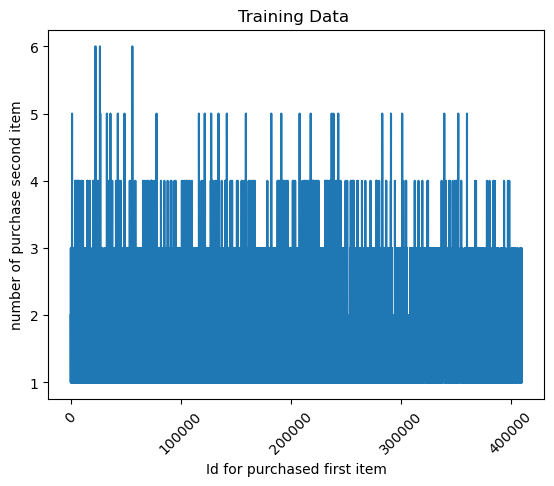

In [ ]:
# plot the result
df1.plot()
plt.title('Training Data ')
plt.xlabel('Id for purchased first item')
plt.ylabel('number of purchase second item')
plt.xticks(rotation=45)
plt.show()

In [ ]:
test_real['Co-Purchase Label'] = 1
test_fake['Co-Purchase Label'] = 0
test_df=pd.concat([test_real, test_fake], ignore_index = True)
test_df = test_df.sample(frac = 1)
test_df=test_df.dropna()
test_df

,PurchaseFirst,PurchaseSecond,Co-Purchase Label
2719,366682,366681,1
16308,173970,341890,0
11839,23356,30093,0
7128,366577,366581,1
441,209991,42325,1
...,...,...,...
553,347223,145547,1
168,379479,222801,1
15277,157850,358878,0
17300,65780,83070,0


In [ ]:
df2 = test_df.groupby(['PurchaseFirst'])["PurchaseSecond"].count()
print(df2)



PurchaseFirst
2         2
8         2
9         1
12        1
17        1
         ..
403226    1
403253    2
403346    2
403351    1
403364    1
Name: PurchaseSecond, Length: 13678, dtype: int64


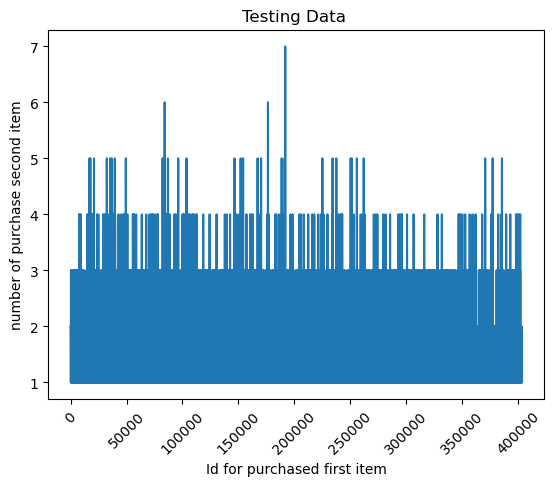

In [ ]:
df2.plot()
plt.title('Testing Data ')
plt.xlabel('Id for purchased first item')
plt.ylabel('number of purchase second item')
plt.xticks(rotation=45)
plt.show()

### 2.3 merge purchasing pair data with item information data

In [ ]:
def merge_metadata_pair(metadata, pairdata):
    first_merge=pd.merge(pairdata, metadata, left_on='PurchaseFirst', right_on='Id', how='left').drop(['Id','Co-Purchase Label','PurchaseSecond'], axis=1)
    first_merge.columns = [col + ' 1' if col not in ['PurchaseFirst'] else col for col in first_merge.columns]
    first_merge['index'] = first_merge.index

    second_merge = pd.merge(pairdata, metadata, left_on='PurchaseSecond', right_on='Id', how='left').drop(['Id', 'PurchaseFirst'], axis=1)
    second_merge.columns = [col + ' 2' if col not in ['PurchaseSecond', 'Co-Purchase Label']else col for col in second_merge.columns]
    second_merge['index'] = second_merge.index

    final_df = pd.merge(first_merge, second_merge, on='index')
    final_df=final_df.drop(columns='index')
    return final_df

In [ ]:
train_df

,PurchaseFirst,PurchaseSecond,Co-Purchase Label
2965,62037,116992,1
7829,10195,10196,1
13498,20561,95137,0
12914,85826,280362,0
12906,115784,184930,0
...,...,...,...
1046,128887,212856,1
3954,28310,5145,1
14024,274782,58980,0
13363,238659,17005,0


In [ ]:
merged_train_df=merge_metadata_pair(metadata,train_df).dropna()


merged_test_df=merge_metadata_pair(metadata,test_df).dropna()

In [ ]:
merged_train_df

,PurchaseFirst,Salesrank 1,Group 1,Average_Rating 1,Main_Category 1,PurchaseSecond,Co-Purchase Label,Salesrank 2,Group 2,Average_Rating 2,Main_Category 2
0,62037,0.962442,1,0.896895,421,116992,1,-0.711630,1,0.896895,253
1,10195,1.122974,1,0.896895,431,10196,1,-0.722915,4,0.646431,103
2,20561,-0.540437,1,0.395966,531,95137,0,-0.292592,1,-1.607746,355
3,85826,-0.854909,1,-1.607746,761,280362,0,-0.397420,1,-0.104962,342
4,115784,-0.706504,1,0.896895,534,184930,0,0.111309,1,0.896895,492
...,...,...,...,...,...,...,...,...,...,...,...
19995,128887,-0.224272,1,-1.607746,348,212856,1,-0.665533,1,0.896895,406
19996,28310,-0.785826,1,0.145502,507,5145,1,0.768815,1,-1.607746,761
19997,274782,1.063854,1,0.646431,212,58980,0,1.431636,1,-1.607746,284
19998,238659,-0.814319,4,0.896895,457,17005,0,2.875862,1,0.646431,361


In [ ]:
merged_train_df[[c for c in merged_train_df if c not in ['Co-Purchase Label']]
       + ['Co-Purchase Label']]

,PurchaseFirst,Salesrank 1,Group 1,Average_Rating 1,Main_Category 1,PurchaseSecond,Salesrank 2,Group 2,Average_Rating 2,Main_Category 2,Co-Purchase Label
0,62037,0.962442,1,0.896895,421,116992,-0.711630,1,0.896895,253,1
1,10195,1.122974,1,0.896895,431,10196,-0.722915,4,0.646431,103,1
2,20561,-0.540437,1,0.395966,531,95137,-0.292592,1,-1.607746,355,0
3,85826,-0.854909,1,-1.607746,761,280362,-0.397420,1,-0.104962,342,0
4,115784,-0.706504,1,0.896895,534,184930,0.111309,1,0.896895,492,0
...,...,...,...,...,...,...,...,...,...,...,...
19995,128887,-0.224272,1,-1.607746,348,212856,-0.665533,1,0.896895,406,1
19996,28310,-0.785826,1,0.145502,507,5145,0.768815,1,-1.607746,761,1
19997,274782,1.063854,1,0.646431,212,58980,1.431636,1,-1.607746,284,0
19998,238659,-0.814319,4,0.896895,457,17005,2.875862,1,0.646431,361,0


In [ ]:
merged_test_df

,PurchaseFirst,Salesrank 1,Group 1,Average_Rating 1,Main_Category 1,PurchaseSecond,Co-Purchase Label,Salesrank 2,Group 2,Average_Rating 2,Main_Category 2
0,366682,-0.788127,8,0.395966,745,366681,1,-0.064574,1,0.395966,143
1,173970,-0.444358,1,0.395966,337,341890,0,-0.861909,4,-1.607746,103
2,23356,-0.220300,4,-1.607746,450,30093,0,-0.185123,1,0.896895,238
3,366577,-0.543396,1,0.896895,352,366581,1,-0.836606,3,0.395966,232
4,209991,2.169220,1,-1.607746,353,42325,1,0.013171,1,-1.607746,164
...,...,...,...,...,...,...,...,...,...,...,...
19995,347223,-0.428485,1,0.896895,487,145547,1,-0.619942,1,0.896895,384
19996,379479,-0.769169,1,0.646431,718,222801,1,5.028687,1,0.896895,754
19997,157850,0.440873,1,-1.607746,567,358878,0,1.487397,1,-1.607746,596
19998,65780,-0.861626,4,0.646431,103,83070,0,0.517999,1,-1.607746,288


### 2.4 train model

In [ ]:
X_train=merged_train_df.drop(['Co-Purchase Label'],axis=1)

y_train=merged_train_df['Co-Purchase Label']
X_test=merged_test_df.drop(['Co-Purchase Label'],axis=1)
y_test=merged_test_df['Co-Purchase Label']

In [ ]:
y_train

0        1
1        1
2        0
3        0
4        0
        ..
19995    1
19996    1
19997    0
19998    0
19999    0
Name: Co-Purchase Label, Length: 19556, dtype: int64

In [ ]:

X_train

,PurchaseFirst,Salesrank 1,Group 1,Average_Rating 1,Main_Category 1,PurchaseSecond,Salesrank 2,Group 2,Average_Rating 2,Main_Category 2
0,62037,0.962442,1,0.896895,421,116992,-0.711630,1,0.896895,253
1,10195,1.122974,1,0.896895,431,10196,-0.722915,4,0.646431,103
2,20561,-0.540437,1,0.395966,531,95137,-0.292592,1,-1.607746,355
3,85826,-0.854909,1,-1.607746,761,280362,-0.397420,1,-0.104962,342
4,115784,-0.706504,1,0.896895,534,184930,0.111309,1,0.896895,492
...,...,...,...,...,...,...,...,...,...,...
19995,128887,-0.224272,1,-1.607746,348,212856,-0.665533,1,0.896895,406
19996,28310,-0.785826,1,0.145502,507,5145,0.768815,1,-1.607746,761
19997,274782,1.063854,1,0.646431,212,58980,1.431636,1,-1.607746,284
19998,238659,-0.814319,4,0.896895,457,17005,2.875862,1,0.646431,361


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

### 2.4.1 Regression

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred=clf.predict(X_test)

# Calculate precision and F1 score for the first target
precision1 = precision_score(y_test, y_pred, average='macro')
f1_score1 = f1_score(y_test, y_pred, average='macro')

# Print the scores
print("Precision:", precision1)
print("F1 Score:", f1_score1)

Precision: 0.5163709042307953
F1 Score: 0.5158656294290873


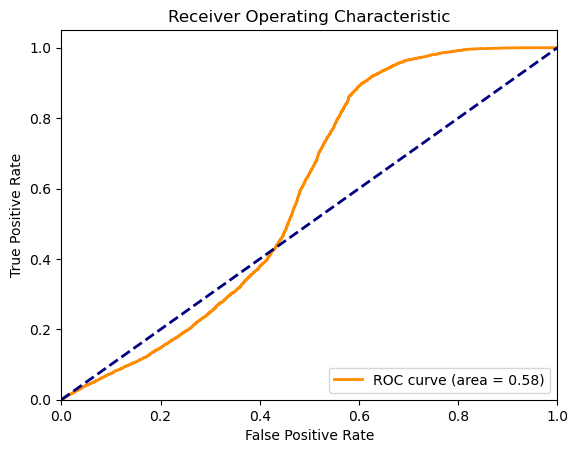

In [ ]:
y_pred_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 2.4.2 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [ ]:
rf_importance=rf.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_importance
})

feature_importances

In [ ]:
feature_importances_sorted = feature_importances.sort_values('Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))  # You can adjust the size of the figure
plt.barh(feature_importances_sorted['Feature'], feature_importances_sorted['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Model')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

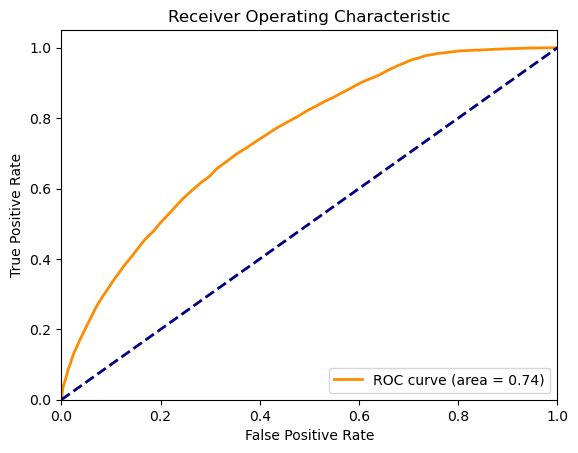

In [ ]:
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf)

# Calculate AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
precision1 = precision_score(y_test, y_pred_rf, average='macro')
f1_score1 = f1_score(y_test, y_pred_rf, average='macro')

# Print the scores
print("Precision:", precision1)
print("F1 Score:", f1_score1)

Precision: 0.6726222357921919
F1 Score: 0.6704881125094043


### 2.4.3 KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn=knn.predict(X_test)

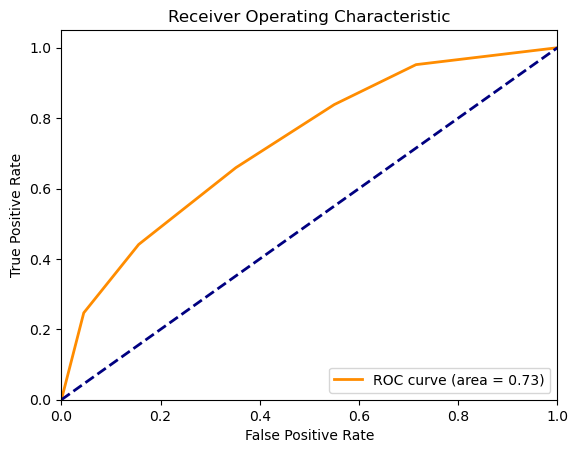

In [ ]:
y_pred_proba_knn = knn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_knn)

# Calculate AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba_knn)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
precision1 = precision_score(y_test, y_pred_knn, average='macro')
f1_score1 = f1_score(y_test, y_pred_knn, average='macro')

# Print the scores
print("Precision:", precision1)
print("F1 Score:", f1_score1)

Precision: 0.6537593307034274
F1 Score: 0.6537288310336079


## Reference

*   Prediction on copurchasing history ( Logistic regression, KNN, Decision Tree, Adaboost etc).
chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://cseweb.ucsd.edu/classes/sp15/cse190-c/reports/sp15/039.pdf